In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
import numpy as np
import tensorflow as tf

import os

from urllib2 import urlopen
import tarfile
import zipfile

# Image manipulation.
import PIL.Image
from IPython.display import Image, display

<!-- requirement: images/chipmunk.jpg -->
<!-- requirement: images/beach.jpg -->
<!-- requirement: images/inception.svg -->

# The Inception Model and the Deep Dream Algorithm

Up until now, we have been dealing with rather shallow networks.  This is primarily due to the time it takes to train deep networks.  We can still play with deep networks, as long as someone else done the work of training for us.

A number of pre-trained models are available from the [TensorFlow models repository](https://github.com/tensorflow/models).  We will use one of these, an early version of the [Inception model](https://github.com/tensorflow/models/tree/master/inception), which does image classification.  We run some image classification ourselves, as well as use it to demonstrate the Deep Dream image manipulation algorithm.

## Inception model

Prior to the introduction of the Inception model, the state of the art for image classification was convolutional neural nets.  Better performance was achieved by increase the depth of the network (the number of layers) as well as the width of the network (the number of channels in each layer).

While successful, these larger networks have two major drawbacks.  First, the increased number of parameters makes the network prone to overfitting, requiring techniques like dropout and large training sets.  Second, this large size also requires significantly more computation resources for training.

It has been known, from both theoretical analysis and biological analogs, that sparser networks should give better performance with fewer parameters.  However, these sparse networks are not a good fit for modern parallel computations: the gain in networks' performance would be washed out by the loss of computational performance in training.

[Szegedy *et al*](https://arxiv.org/pdf/1409.4842v1.pdf) realized that they could mimic this sparsity out of a collection of dense elements.  They designed an **inception module** out of several small convolutional elements, and then stacked these blocks together.  (Yes, the name came from the movie.)  The particular network we're examining here is an early instance dubbed GoogLeNet.  It won one of the 2014 ImageNet challenges, beating the accuracy of previous winners while using $1/12$ as many parameters.  The architecture is sketched in below.  (We are neglecting two auxiliary classifiers used to help train the lower levels.)

![inception](images/inception.svg)

After some initial convolutional and normalization layers, a series of nine inception modules run in series.  The output is combined into a fully-connected layer and then a softmax classifier.

The inception module uses several $1\times1$ convolutional elements.  At first, this may seem to be useless.  After all, a $1\times1$ kernel would just multiply each input pixel by the value of the kernel.  Remember that the kernel also extends across, and mixes, all of the channels of the image.  These kernels are generating new features by mixing the input features.  In these cases, there are fewer output channels than input channels, so these convolutions act as dimensional reductions.  (A [following paper](https://arxiv.org/pdf/1512.00567v3.pdf) by the same group suggests some slight modifications to this scheme.)

All of the convolutions in the inception modules use the "same" padding.  This ensures that each of the four paths through the module have the same image dimensions, so the outputs can be stacked as separate channels.  The interplay between the dimensional reduction and the stacking is such that number of parameters in each inception module is roughly comparable.

### Getting the model

The following code will download the trained GoogLeNet model and save it locally.

In [3]:
data_url = "http://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip"
data_dir = os.path.expanduser("~/inception/5h/")
file_path = os.path.join(data_dir, 'inception5h.zip')

if not os.path.exists(file_path):
    # Check if the download directory exists, otherwise create it.
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    # Download
    with open(file_path, "wb") as local_file:
        local_file.write(urlopen(data_url).read())
    # Extract
    zipfile.ZipFile(file_path, mode="r").extractall(data_dir)

The model is stored in Google's [Protocol Buffer](https://developers.google.com/protocol-buffers/) format.  TensorFlow makes it easy to load the graph.

In [4]:
graph = tf.Graph()
with graph.as_default():
    path = os.path.join(data_dir, "tensorflow_inception_graph.pb")
    with tf.gfile.FastGFile(path, 'rb') as file:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(file.read())
        tf.import_graph_def(graph_def, name='')

session = tf.InteractiveSession(graph=graph)

The graph has been reconstructed, but we don't have Python references to any of the tensors.  Luckily for us, the creators of the graph gave the operations sensible names.  Therefore, we can get references to the tensors with the `get_tensor_by_name` method.  (The `:0` suffix indicates that these live on the first, and in this case only, computational device.)  We'll use this to get the input and final output of the net.

In [5]:
graph_input = graph.get_tensor_by_name("input:0")
graph_output = graph.get_tensor_by_name("output2:0")

The output of the graph will be the probability of the image belonging to each of about 1000 image classes from the ImageNet competition.  Those labels are stored in a text file.

In [6]:
labels = map(lambda s: s.strip(),
             open(os.path.join(data_dir, 'imagenet_comp_graph_label_strings.txt')).readlines())
labels[0:10]

['dummy',
 'kit fox',
 'English setter',
 'Siberian husky',
 'Australian terrier',
 'English springer',
 'grey whale',
 'lesser panda',
 'Egyptian cat',
 'ibex']

Let's load up an image and try it out.  Here's a photograph the author took at Point Reyes:

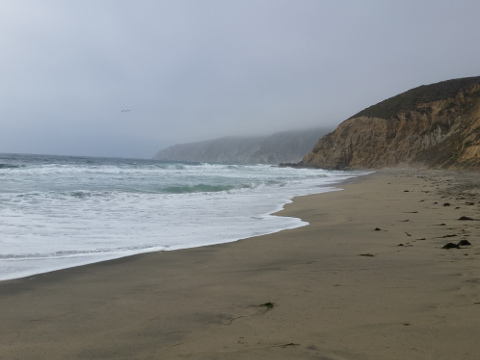

In [7]:
beach = PIL.Image.open('images/beach.jpg')
beach

This network is designed to work with $224\times224$ pixel input images.  For the ImageNet competition, the team took 144 different crops of the image, ran each through the model, and then averaged the softmax probabilities.  We won't go through that much work; we'll just resize the image down to the input size and send it through.  (The call to `np.expand_dims` is necessary because the network expects a stack of images as input.)

In [8]:
image = np.uint8(beach.resize((224, 224)))
res = session.run(graph_output, {graph_input: np.expand_dims(image, axis=0)})

By looking up the label for the highest probability, we get our prediction:

In [9]:
labels[res[0].argmax()]

'seashore'

Not bad!  We can also look at the top predictions, all of which seem fairly reasonable.

In [10]:
for i in res.argsort()[0][-1:-6:-1]:
    print labels[i], res[0,i]

seashore 0.762701
promontory 0.182593
breakwater 0.017713
sandbar 0.0165398
lakeside 0.00438705


Let's try it with another image.

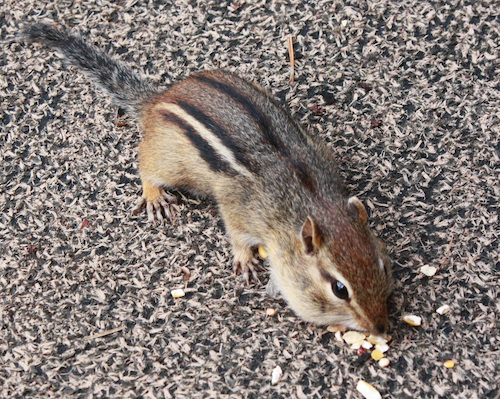

In [11]:
chipmunk = PIL.Image.open('images/chipmunk.jpg')
chipmunk

In [12]:
image = np.uint8(chipmunk.resize((224, 224)))
res = session.run(graph_output, {graph_input: np.expand_dims(image, axis=0)})

for i in res.argsort()[0][-1:-6:-1]:
    print labels[i], res[0,i]

wood rabbit 0.621837
hare 0.245159
bittern 0.0297976
wallaby 0.0212032
wild boar 0.0135625


The model is somewhat confident that this is a [wood rabbit](http://www.image-net.org/synset?wnid=n02325366).  On the one hand, it's a bit of an odd misclassification; on the other, they aren't entirely dissimilar.

This becomes more reasonable when you consider:

In [13]:
'chipmunk' in labels

False

The model wasn't trained on chipmunks, so it could not classify the image as one, nor could it learn the differences between chipmunks and rabbits.

## The Deep Dream Algorithm

But simply classifying images is not the only thing we can do with an inception network.  We can use deep learning to [create artwork](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html?m=1) as well. Using the [Deep Dream](https://en.wikipedia.org/wiki/DeepDream) algorithm, we can modify images by amplifying the features detected by neural networks. We calculate the gradients in the model and then update the image accordingly. 

To create our artwork we will do the following:

1. Select a layer in the inception model
2. Feed the model an image
3. Calculate the gradient in the layer with respect to the image
4. Update the gradient to the image
5. Goto 3

We've selected 12 layers from this model that we can explore.  These layers are highlighted and named in the previous architectural diagram.

In [14]:
#get graph
layer_names = ['conv2d0', 'conv2d1', 'conv2d2', 'mixed3a', 
               'mixed3b', 'mixed4a', 'mixed4b', 'mixed4c', 
               'mixed4d', 'mixed4e', 'mixed5a', 'mixed5b']

layer_tensors = [graph.get_tensor_by_name(name + ":0") for name in layer_names]

### Optimize step

The goal of the Deep Dream algorithm is to make an image that creates the largest activations in some particular layer.  We don't care about the sign of these activations, so we try to maximize the mean squared activation value.

TensorFlow's automatic differentiation allows us to take the gradient of this quantity with respect to each pixel in the input image.  By adding a term proportional to the gradient to the image, we should increase the overall activation.  By repeating this process, we allow the feedback to amplify interesting patterns in the image.

In [ ]:
def optimize(graph_input, layer_tensor, image,
             num_iterations=10, step_size=3.0):

    # Convert image to np array
    img = np.float32(image)

    # Calculate gradient
    activation = tf.reduce_mean(tf.square(layer_tensor))
    gradient = tf.gradients(activation, graph_input)[0]

    for i in range(num_iterations):
        # Calculate the value of the gradient.
        grad = session.run(gradient,
                           {graph_input: np.expand_dims(img, axis=0)})
        grad /= (np.std(grad) + 1e-8)
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        grad = grad.reshape(img.shape)
        img += grad * step_size_scaled

    return np.clip(img, 0.0, 255.0).astype(np.uint8)

Now we can choose an input image and target layer, and run the process for several steps.

In [ ]:
mg_result = optimize(graph_input, layer_tensors[5], chipmunk,
                     num_iterations=10, step_size=6.0)

display(PIL.Image.fromarray(mg_result))

### Exploring the layers

By looking at the features amplified at the different levels, we can get an idea of the features each layer is trying to detect.  We see that the lower levels detect simple patterns.  These serve as the building blocks for more complicated patterns deeper into the network.

mixed4e:0


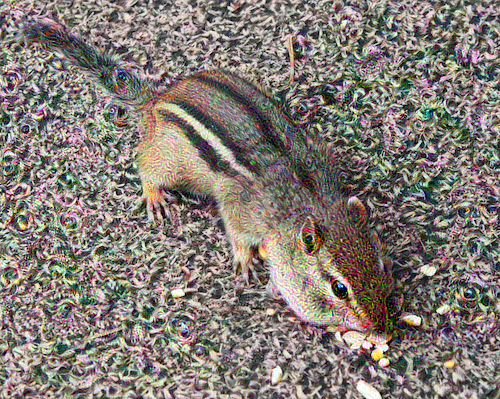

mixed5a:0


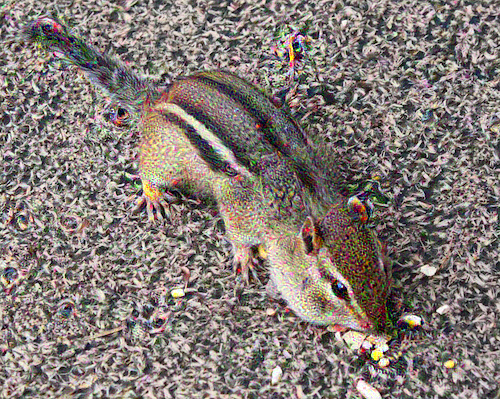

mixed5b:0


In [ ]:
for layer in layer_tensors:
    mg_result = optimize(graph_input, layer, chipmunk, num_iterations=10, step_size=6.0)
    print layer.name
    display(PIL.Image.fromarray(mg_result))

### Exercises: 

1. First play around with the layer number. The higher numbers correspond to more complex shapes that the model recognizes. 
2. Upload your own picture and perform the DeepDream algorithm on it. 
3. Don't square the tensor before you calculate the gradient. How does this change your results?

*Copyright &copy; 2017 The Data Incubator.  All rights reserved.*